<a href="https://colab.research.google.com/github/trzxf/Machine_learning/blob/main/Deep%20Learning(non-image).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
Epoch 1/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0075 - val_loss: 3.4027e-04
Epoch 2/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.6726e-04 - val_loss: 2.3995e-04
Epoch 3/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.0324e-04 - val_loss: 2.6883e-04
Epoch 4/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.5516e-04 - val_loss: 1.9355e-04
Epoch 5/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.4717e-04 - val_loss: 2.1059e-04
Epoch 6/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.2604e-04 - val_loss: 1.7819e-04
Epoch 7/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.2087e-04 - val_loss: 1.7996e-04
Epoch 8/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 3.1540e-04 - val_loss: 2.0052e-04
Epoch 9/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.1442e-04 - val_loss: 1.7221e-04
Epoch 10/50
1185/1185 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3.1279e-04 - val_loss: 1.8832e-04
Epoch 11/50
1185/1185 ━

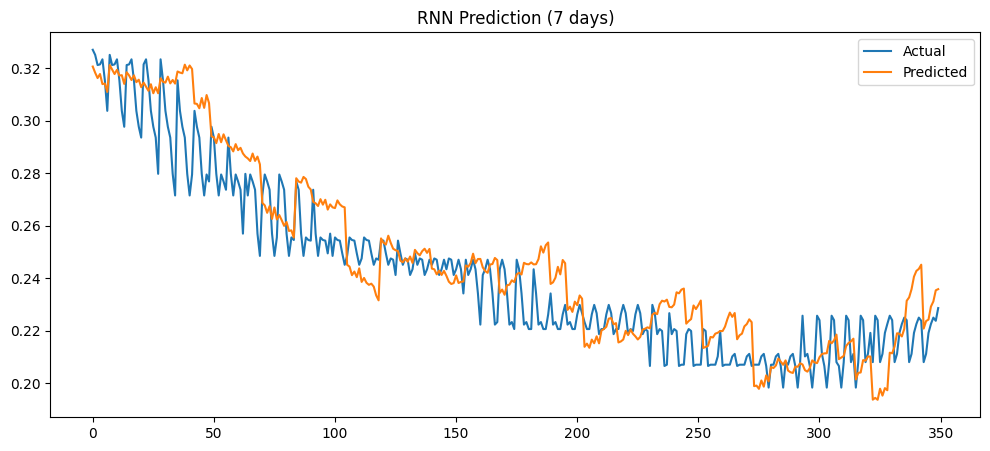

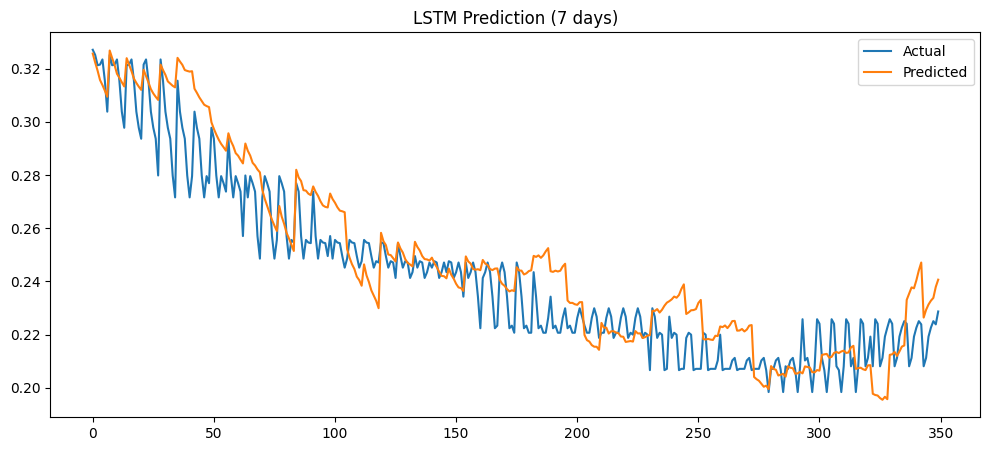

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load & Preprocess Dataset
df = pd.read_csv('/content/cleaned_weather.csv', parse_dates=['date'])
df = df[['date', 'T']].dropna()
df = df.sort_values('date')

# 2. Scaling
scaler = MinMaxScaler()
df['T_scaled'] = scaler.fit_transform(df[['T']])

# 3. Sequence generation: 30 hari input → 7 hari output
def create_sequences(data, input_len=30, output_len=7):
    X, y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

series = df['T_scaled'].values
X, y = create_sequences(series, input_len=30, output_len=7)

# 4. Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train[..., np.newaxis]  # shape: (samples, 30, 1)
X_test = X_test[..., np.newaxis]

# 5. Build RNN & LSTM models
def build_rnn(input_shape, output_len):
    model = Sequential([
        SimpleRNN(64, activation='tanh', input_shape=input_shape),
        Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape, output_len):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape),
        Dense(output_len)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 6. Train models
es = EarlyStopping(patience=5, restore_best_weights=True)

model_rnn = build_rnn((30, 1), 7)
model_lstm = build_lstm((30, 1), 7)

print("Training RNN...")
model_rnn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

print("Training LSTM...")
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[es], verbose=1)

# 7. Evaluation
def evaluate(model, X, y, name):
    pred = model.predict(X)
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f"{name} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return pred

y_pred_rnn = evaluate(model_rnn, X_test, y_test, "RNN")
y_pred_lstm = evaluate(model_lstm, X_test, y_test, "LSTM")

# 8. Plot
def plot_result(y_true, y_pred, title):
    plt.figure(figsize=(12,5))
    plt.plot(y_true[:50].flatten(), label='Actual')
    plt.plot(y_pred[:50].flatten(), label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

plot_result(y_test, y_pred_rnn, "RNN Prediction (7 days)")
plot_result(y_test, y_pred_lstm, "LSTM Prediction (7 days)")
